In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from bayes3d._mkl.table_scene_model import *
from bayes3d._mkl.utils import *
import matplotlib.pyplot as plt

In [3]:
import jax
from jax import jit, vmap
import jax.numpy as jnp
import os
import bayes3d as b3d
import trimesh

key = jax.random.PRNGKey(0)

In [4]:
import genjax
from genjax import gen

## Renderer and meshes

In [5]:
_scaling  = 1e-3
model_dir = os.path.join(b3d.utils.get_assets_dir(),"bop/ycbv/models")

meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    mesh = trimesh.load(mesh_path)
    mesh.vertices *= _scaling 
    meshes.append(mesh)


# Add invisible atomic table
mesh_path = os.path.join(b3d.utils.get_assets_dir(), "sample_objs/cube.obj")
mesh = trimesh.load(mesh_path)
mesh.vertices *= 1e-9
meshes.append(mesh)


In [6]:
w = 200
h = 200
f = 300
intr = b3d.Intrinsics(
    width = w, height = h,
    fx = f, fy = f,
    cx = w/2 - 0.5, cy = h/2 - 0.5,
    near = 1e-4, far = 5.0
)
b3d.setup_renderer(intr)
for mesh in meshes: b3d.RENDERER.add_mesh(mesh, center_mesh=True)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (224, 224, 1024)


In [7]:
def prep_im(Y, far=5.0, eps=1e-6):
    im = jnp.where(Y[:,:,2]>= far - eps, jnp.inf, Y[:,:,2])
    return im

## Table Scene

In [8]:
fname = f"table_scene_2"

data = jnp.load(f"data/likelihood_test/{fname}.npy", allow_pickle=True)
data = data.item()

scene_ch = data["choices"]
cam      = data["choices"]["camera_pose"]
table    = data["choices"]["root_pose_0"]
scene_model_args = data["args"]

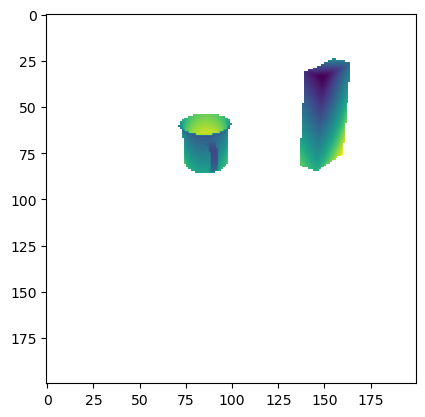

In [9]:
key = keysplit(key)

scene_model = make_table_scene_model()
w, tr = scene_model.importance(key, scene_ch, scene_model_args)
cam, ps, inds = tr.retval

X = b3d.RENDERER.render(inv(cam) @ ps , inds)

# =====================
plt.imshow(prep_im(X))

In [10]:
def get_patch(X, c, w, h):
    i = int(c[1])
    j = int(c[0])
    patch = X[ i-h : i+h+1 , j-w : j+w+1 ]
    return patch

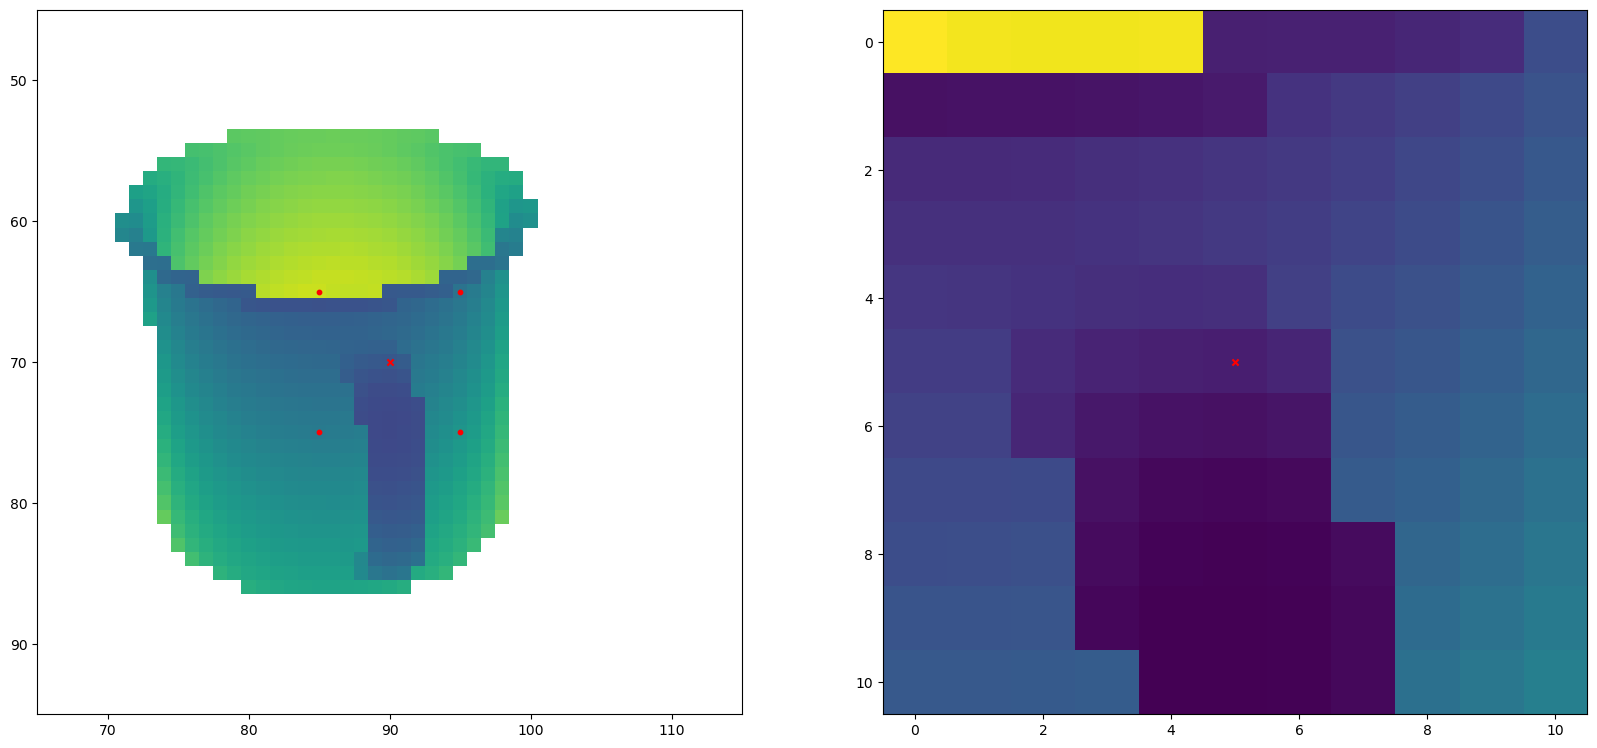

In [11]:
c = jnp.array([90,70])
att_w  = 5
att_h  = 5

patch = get_patch(X, c, att_w, att_h)

# =====================
fig, axs = plt.subplots(1, 2, figsize=(20,10))
axs[0].set_xlim(c[0]-att_w-20, c[0]+att_w+20)
axs[0].set_ylim(c[1]+att_h+20, c[1]-att_h-20)
axs[0].imshow(prep_im(X))
axs[0].scatter(*c, c="r", s=20, marker="x")
axs[0].scatter(c[0]-att_w, c[1]-att_h, c="r", s=10)
axs[0].scatter(c[0]-att_w, c[1]+att_h, c="r", s=10)
axs[0].scatter(c[0]+att_w, c[1]-att_h, c="r", s=10)
axs[0].scatter(c[0]+att_w, c[1]+att_h, c="r", s=10)

axs[1].imshow(prep_im(patch))
axs[1].scatter(att_w,att_h, c="r", s=20, marker="x")


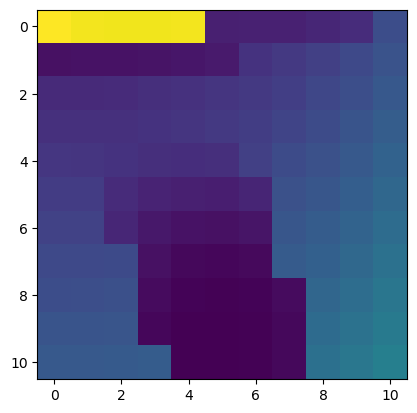

In [144]:
from bayes3d._mkl.simple_likelihood import make_simple_step_sensor_model


sensor_model = make_simple_step_sensor_model(5.0)
key = keysplit(key)
X_ = sensor_model(patch[...,:3], 1e-6, 0.0)(key)

# =====================
plt.imshow(prep_im(X_, far=4.5))

## Patch model

In [162]:
from bayes3d._mkl.simple_likelihood import wrap_into_dist

def score_images(observed, rendered, sig, *args):
    distances = jnp.linalg.norm(observed - rendered, axis=-1)
    return (distances < sig).mean()


sensor_model = wrap_into_dist(score_images)

In [163]:
X_.shape
sensor_model(X_, 0.01)(key).shape

(11, 11, 3)

In [194]:
from genjax import tfp_uniform as uniform


def make_patch_model(scene_model_args):

    scene_model  = make_table_scene_model()
    # sensor_model = make_simple_step_sensor_model(5.0)
    sensor_model = wrap_into_dist(score_images)

    @genjax.gen
    def patch_model(sig, out):

        cam, ps, inds = scene_model(*scene_model_args) @ "scene"
        Y = b3d.RENDERER.render(inv(cam) @ ps , inds)
        # X = sensor_model.inline(Y[...,:3], sig, out)
        X = sensor_model(Y[...,:3], sig, out) @ "X"

        return X,Y

    return patch_model


In [176]:
w_orig = h_orig = 200
w_att  = h_att  = 5
fx     = fy     = 300
center = jnp.array([90., 70.])

intr = b3d.Intrinsics(
    width = 2*w_att+1, height = 2*h_att+1,
    fx    = fx,    fy     = fy,
    cx    = w_orig/2 - 0.5 + w_att - center[0],  cy = h_orig/2 - 0.5  + h_att - center[1],
    near = 1e-4, 
    far  = 5.0
)
b3d.setup_renderer(intr)
for mesh in meshes: b3d.RENDERER.add_mesh(mesh, center_mesh=True)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (32, 32, 1024)


In [195]:
scene_model_args = (
    jnp.arange(2),
    jnp.arange(22),
    jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
    jnp.array([jnp.array([-0.2, -0.2, -2*jnp.pi]), jnp.array([0.2, 0.2, 2*jnp.pi])]),
    b3d.RENDERER.model_box_dims
)

model = make_patch_model(scene_model_args)

-33.208347


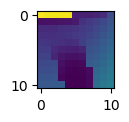

In [196]:
ch = genjax.choice_map({
    "scene": genjax.choice_map({
        "parent_0": -1,
        "parent_1":  0,
        "camera_pose": cam,
        "root_pose_0": table,
        "id_0": jnp.int32(21), # Atomic Table
        "id_1": jnp.int32(13), # Mug
        "face_parent_1": 1,  # That's the top face of the table
        "face_child_1": 3,   # That's a bottom face of the mug
        "contact_params_1": scene_ch["contact_params_1"],
    }),
    # "X": genjax.vector_choice_map({
    #             "measurement":  
    #         }) 
})


sig = 1e-6
out = 0.0

key = keysplit(key)
_, tr0 = model.importance(key, ch, (sig, out))

print(tr0.score)

P, _ = tr0.retval
# ========================
plt.figure(figsize=(1,1))
plt.imshow(prep_im(P, far=4.5))

In [197]:
from bayes3d._mkl.plotting import *


def get_linear_grid(shape, bounds, flat=False):
    """Create a (linear) grid of a given shape and bounds."""
    
    linspaces = [jnp.linspace(*b, d) for b,d in zip(bounds, shape)]
    vs = jnp.stack(jnp.meshgrid(*linspaces, indexing='ij'), axis=-1)
    if flat: vs = vs.reshape(-1,len(shape))
    
    return vs

In [198]:
def update(key, tr0, v):
    ch = genjax.choice_map({ "scene": 
            genjax.choice_map({
                "contact_params_1": v,
            })
    })
    diffs = argdiffs(tr0.args)
    (_, w, tr1, _) = tr0.update(key, ch, diffs)
    return tr1

In [199]:
def _eval_contact(key, tr0, v):
    ch = genjax.choice_map({ "scene": 
            genjax.choice_map({
                "contact_params_1": v,
            })
    })
    diffs = argdiffs(tr0.args)
    (_, w, tr1, _) = tr0.update(key, ch, diffs)

    return tr1.get_score()


eval_contact = jit(vmap(_eval_contact, (None,None,0)))


In [201]:
sig = 0.01
out = 0.1
key = keysplit(key)
_, tr0 = model.importance(key, tr0.strip(), (sig, out))
print(tr0.score)

-33.208347


(42875, 3)
(11, 11)
174 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

    - infs: 0
    + infs: 0
       nan: 0



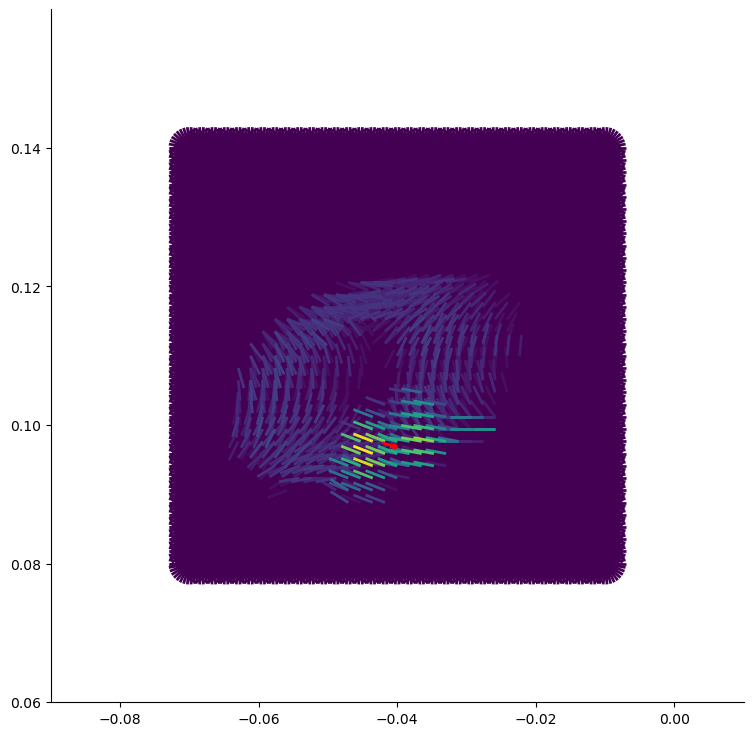

In [202]:
dx  = 0.03
dhd = jnp.pi
v0 = scene_ch["contact_params_1"]
vs = get_linear_grid((35, 35, 35), ((-dx,dx), (-dx,dx), (-dhd,dhd)), flat=True)
vs += jnp.array([-0.04,0.11, 0.0])

print(vs.shape)
print((b3d.RENDERER.intrinsics.height, b3d.RENDERER.intrinsics.width))

sc = eval_contact(key, tr0, vs)
%timeit -n 1 -r 1 eval_contact(key, tr0, vs).block_until_ready();

print(f"""
    - infs: {jnp.sum(sc == -jnp.inf)}
    + infs: {jnp.sum(sc ==  jnp.inf)}
       nan: {jnp.sum(jnp.isnan(sc))}
""")



r = 0.003
# =======================================
fig, ax = plt.subplots(1,1,figsize=(9,9))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
zoom_in(vs[:,:2], 0.02, ax=ax)
plot_poses(vs, sc, r=r, linewidth=2, ax=ax, q=0.98)
plot_pose(scene_ch["contact_params_1"], r=r/2, c="red")
plt.scatter(*v0[:2], c="r", s=10)

0


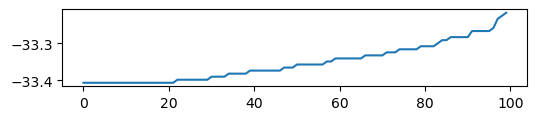

In [204]:
print(jnp.sum(sc == -jnp.inf))

order = jnp.argsort(sc)
# =================
plt.figure(figsize=(6,1))
plt.plot(sc[order][-100:])

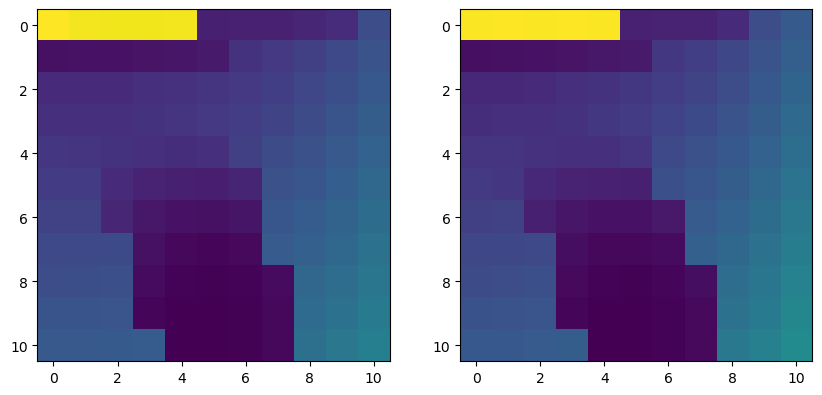

In [205]:
order = jnp.argsort(sc)

tr1 = update(key, tr0, vs[order[-1]])

X, Y = tr1.retval

fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(prep_im(X, far=4.5))
axs[1].imshow(prep_im(Y, far=4.5))

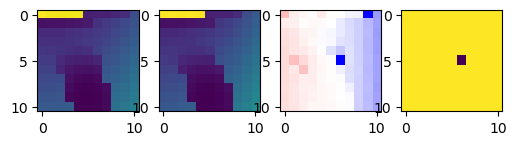

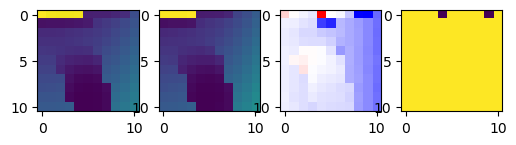

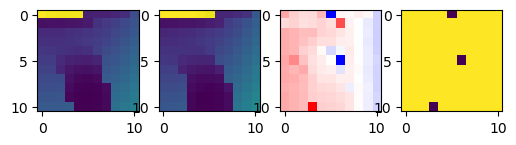

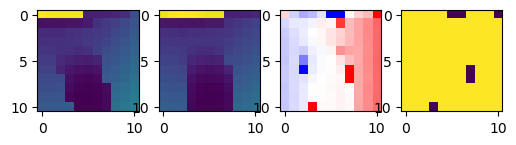

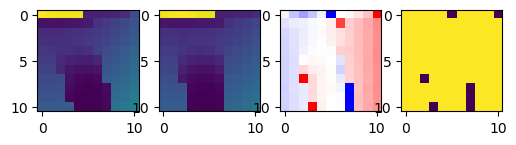

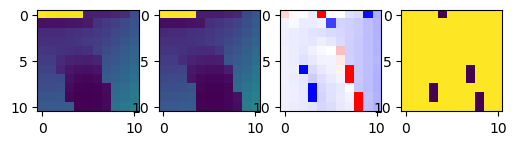

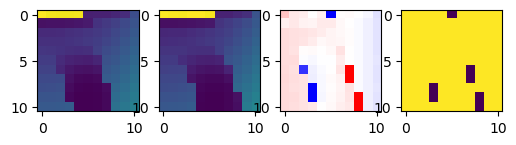

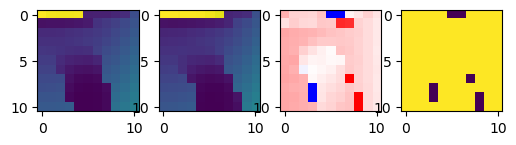

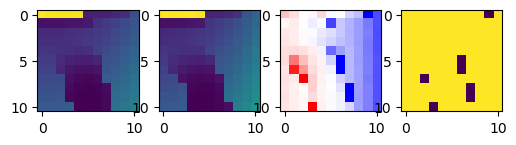

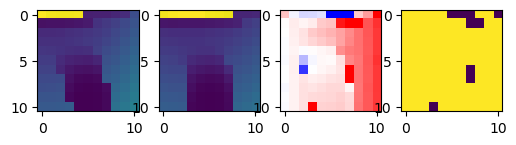

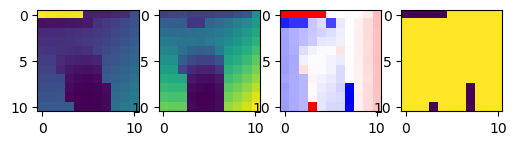

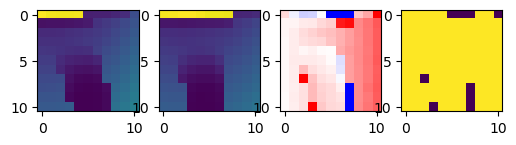

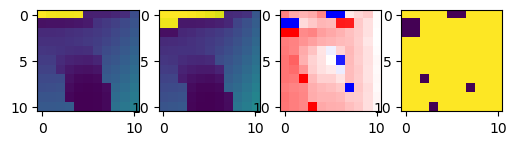

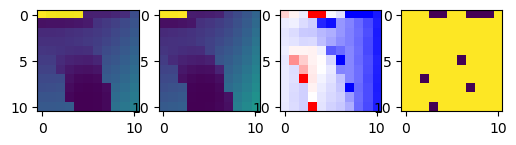

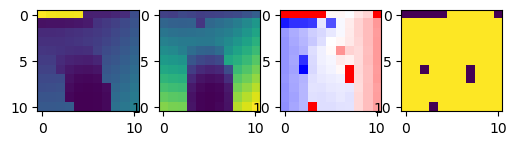

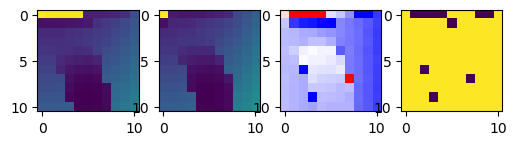

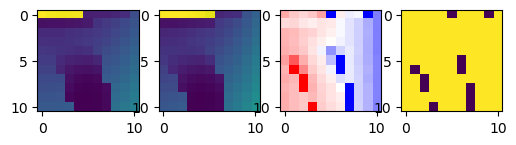

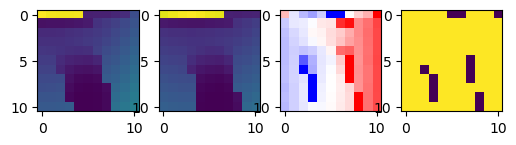

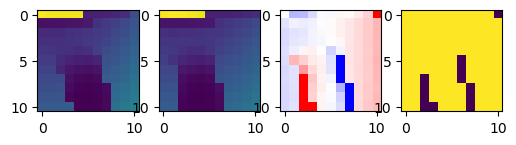

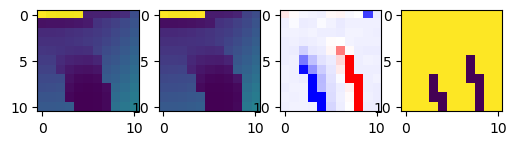

In [206]:
order = jnp.argsort(sc)[::-1]

for i in range(20):
    tr1 = update(key, tr0, vs[order[i]])

    X, Y = tr1.retval
    fig, axs = plt.subplots(1,4, figsize=(6,2))
    axs[0].imshow(prep_im(X, far=4.5))
    axs[1].imshow(prep_im(Y, far=4.5))
    axs[2].imshow(X[...,2] - Y[...,2], cmap="bwr", vmin=-sig, vmax=sig)
    axs[3].imshow(jnp.linalg.norm(X[...,:3] - Y[...,:3], axis=-1) < sig)